In [1]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('../')

In [2]:
from util.utils import ConfigDict, PRNGSequence
from util.scms import gen_scm
from genDM.configs import train_config as config, handle_config
from util.dataset import JaxDataset, NumpyLoader

from genDM.trainer import MLETrainer, MinMaxTrainer, OptimalAdvTrainer
from genDM.losses import y2_loss
from genDM.models import CPM

import tqdm
import matplotlib.pyplot as plt

### Data Load

In [3]:
rng = PRNGSequence(config.gc.seed)
scm = gen_scm(config.gc.dataset)
config = handle_config(config, scm)  # Update config based on the data
dl = NumpyLoader(JaxDataset(scm.generate(next(rng), config.gc.n_samples)), batch_size=config.gc.batch_size)

### MLE for log p_true(t|x)

In [4]:
mle_trainer = MLETrainer(config.gc, config.mle_config, config.doc)
mle_trainer.initialize(next(rng))
with tqdm.tqdm(total=config.gc.MLE_epochs) as pbar:
    for epoch in range(config.gc.MLE_epochs):
        for batch in dl:
            outputs = mle_trainer.train_step(next(rng), batch)
        logging_str = ' '.join(
            ['{}: {: <10g}'.format(k, v) for (k, v) in outputs.items()]) if outputs is not None else ''
        pbar.set_postfix_str(logging_str)
        pbar.update(1)

100%|██████████| 100/100 [00:03<00:00, 25.90it/s, log_likelihood: -1.42091  ]


### DRO (Optimal Adversary)

In [5]:
config.dmc

{'features': [5, 1],
 'activation': 'relu',
 'condition_dim': 1,
 'decision_dim': 1,
 'variance': 1}

In [6]:
target_loss = y2_loss(scm)
opt_adv_trainer = OptimalAdvTrainer(target_loss=target_loss,
                                   log_p_true=mle_trainer.log_p,
                                   global_config=config.gc,
                                   decision_model_config=config.dmc,
                                   decision_optim_config=config.doc)
dl = NumpyLoader(JaxDataset(scm.data), batch_size=config.gc.batch_size)  # Reload the data
opt_adv_trainer.initialize(next(rng))
config.gc.debug = False
with tqdm.tqdm(total=config.gc.epochs) as pbar:
    with tqdm.tqdm(total=config.gc.epochs) as dbar:
        for epoch in range(config.gc.epochs):
            for batch in dl:
                outputs, debug = opt_adv_trainer.train_step(next(rng), batch)
            logging_str = ' '.join(['{}: {: .4f}'.format(k, v) for (k, v) in outputs.items()])
            pbar.set_postfix_str(logging_str)
            pbar.update(1)
            if config.gc.debug:
                debug_str = ' '.join(['{}: {: .4f}'.format(k, v) for (k, v) in debug.items()])
                dbar.set_postfix_str(debug_str)
                dbar.update(1)

100%|██████████| 1000/1000 [00:22<00:00, 43.83it/s, lagrange_param:  nan log_pi_theta:  nan loss:  nan]


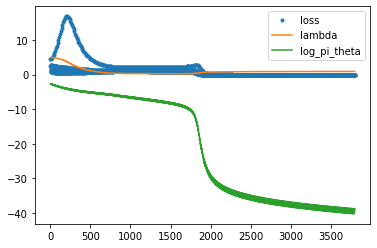

In [13]:
plt.plot(opt_adv_trainer.train_metrics['loss'], '.', label='loss')
plt.plot(opt_adv_trainer.train_metrics['lagrange_param'], label='lambda')
plt.plot(opt_adv_trainer.train_metrics['log_pi_theta'], label='log_pi_theta')
plt.legend()
plt.show()

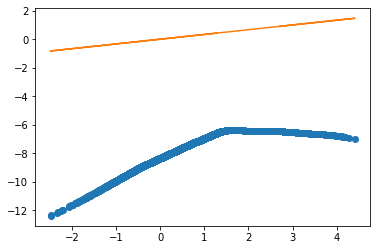

In [7]:
# Plot the learned policy
mu_x = opt_adv_trainer.decision_state.apply_fn({'params': opt_adv_trainer.decision_state.params},
                                              scm.data[:, config.gc.batch_condition_dims],
                                              method=CPM.mu)
plt.plot(scm.data[:, config.gc.batch_condition_dims], mu_x, 'o')
plt.plot(scm.data[:, config.gc.batch_condition_dims], scm.data[:, config.gc.batch_condition_dims]/3, '-')